# Business Context

The Standard and Poor's 500 (or S&P 500) is a stock market index tracking the performance of 500 large companies listed on stock exchanges in the United States. As of December 31, 2020, more than $5.4 trillion was invested in assets tied to the performance of this index.

The S&P 500 index is a free-float weighted/capitalization-weighted index. As of September 30, 2021, the nine largest companies on the list of S&P 500 companies accounted for 28.1% of the market capitalization of the index and were, in order of weighting, Apple, Microsoft, Alphabet (including both class A & C shares), Amazon.com, Facebook, Tesla, Nvidia, Berkshire Hathaway and JPMorgan Chase. The components that have increased their dividends in 25 consecutive years are known as the S&P 500 Dividend Aristocrats. (Source of information: https://en.wikipedia.org/wiki/S%26P_500)

Many people buy stocks when they put their money into RRSP for example. We all hope that at the end of the year, we will gain a significant percentage compare to what we put at the beginning of the year. The objective is to know which compagnies will obtain the highest increase of their stock price at the market closure. 

However, we are interested to know which companies have the greatest increase of stock price over the years and try to foresee if they will keep on this increase using time series. Moreover, we wnat to know which sector of activities is suitable to invest each year based on market opening and closure stock prices.

# Dataset Creation
We want to download a first dataset containing all companies listed in the S&P 500 with their sector of activities. Then we want to download the stock market index information for each of these companies from 1990-01-01 to today. We merge these 2 datasets to form only one dataset containing only the companies having stock market indices.

In [1]:
# Mount your Google Drive repository and select the folder to work in.
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/SP500Stocks
PATH = "/content/drive/MyDrive/Colab\ Notebooks/SP500Stocks"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SP500Stocks


In [2]:
# Import of the main libraries.
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import Dashboard

from platform import python_version
print("Python version: " + python_version())

import importlib.util
import importlib
import subprocess
import sys

def installPackageIfNotInstalled(library_name):
    spec = importlib.util.find_spec(library_name)
    if spec is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", library_name]) 

Python version: 3.7.12


In [3]:
## Source: https://datahub.io/core/s-and-p-500-companies#python
installPackageIfNotInstalled("datapackage")
from datapackage import Package

def downloadCompanyBasicInformation():
    package = Package('https://datahub.io/core/s-and-p-500-companies/datapackage.json')

    # Store list of lists of 3 strings from the JSON file: 
    # Company abbreviation, company name and sector of activities.
    companies = list()
    for resource in package.resources:
        if resource.descriptor['datahub']['type'] == 'derived/csv':
            companies = resource.read()
    
    return companies

companies = downloadCompanyBasicInformation()
with open("Companies.csv", "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['CompanyAbbreviation', 'CompanyName', 'CompanySector'])
    writer.writerows(companies)

In [4]:
installPackageIfNotInstalled("yfinance")
import yfinance as yf

def downloadStockIndicesToCSVFile(companies):
    dataset_list = list()
    for company in companies:
        data = yf.download(tickers=company, 
                        group_by="Ticker", 
                        start='1989-12-31', 
                        progress=False)
        data['CompanyAbbreviation'] = company 
        dataset_list.append(data)

    # combine all dataframes into a single dataframe
    return pd.concat(dataset_list)

# Download the stock indices information for each company.
companies = [company[0] for company in companies]
stock_indices = downloadStockIndicesToCSVFile(companies)
stock_indices.to_csv('StockIndices.csv')


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [5]:
# Merge the companies.csv file with the StockIndices.csv by the Abbreviation column.
def mergeStockIndicesOnCompanyAbbreviation():
    stock_indices = pd.read_csv("StockIndices.csv")
    companies = pd.read_csv("Companies.csv")
    
    return stock_indices.merge(companies, on="CompanyAbbreviation", how="inner")
    
stock_indices = mergeStockIndicesOnCompanyAbbreviation()
stock_indices.to_csv("Stocks.csv", index=False)
stock_indices

,Date,Open,High,Low,Close,Adj Close,Volume,CompanyAbbreviation,CompanyName,CompanySector
0,1990-01-02,19.843750,20.156250,19.781250,20.125000,8.178860,1496000.0,MMM,3M,Industrials
1,1990-01-03,20.156250,20.468750,20.125000,20.343750,8.267760,2631600.0,MMM,3M,Industrials
2,1990-01-04,20.218750,20.750000,20.218750,20.500000,8.331256,2538400.0,MMM,3M,Industrials
3,1990-01-05,20.406250,20.500000,20.156250,20.156250,8.191559,1825600.0,MMM,3M,Industrials
4,1990-01-08,20.125000,20.718750,20.125000,20.687500,8.407458,2164400.0,MMM,3M,Industrials
...,...,...,...,...,...,...,...,...,...,...
3278474,2022-01-14,206.940002,207.399994,203.410004,206.179993,206.179993,2209100.0,ZTS,Zoetis,Health Care
3278475,2022-01-18,201.800003,204.289993,200.330002,202.699997,202.699997,2433800.0,ZTS,Zoetis,Health Care
3278476,2022-01-19,202.839996,205.899994,200.059998,200.580002,200.580002,2159600.0,ZTS,Zoetis,Health Care
3278477,2022-01-20,201.000000,206.250000,200.970001,201.960007,201.960007,2844200.0,ZTS,Zoetis,Health Care


Each observation (row) in the Stocks.csv file represents a stock index information on a certain day. The columns representing the features are explained in the following table:

| Feature Name | Type | Description | 
| :- | - | - |
| Date | Date | Date (YYYY-MM-DD) of opening and closing of the stock price. |
| Open | Real | price of the stock unit at market opening (this is NYSE data so all in USD). |
| High | Real | Highest price reached in the day. |
| Low | Real | Lowest price reached in the day. |
| Close | Real | Adjusted price of the stock unit at market closure. |
| Adj Close | Real | Adjusted close price adjusted for splits and dividend and/or capital gain distributions. |
| Volume | Real | Number of shares traded. |
| Abbreviation | String | The stock's company abbreviation. |
| Name | String | The stock's company name. |
| Sector | String | The stock's company's sector of activity. | 

# Dashboards
For someone who wants to sell his shares, it is optimal to know at which period of the year the highest stock price is reached. Also, when investing to buy shares, the invester needs to know when it is a good time to buy and in which company it will be profitable in a short or long term. Predict the stock price depends on a large number of variables that we do not have. Thus, we show the past and actual gains of the companies in the S&P 500 in dashboards.

The objective is to display a dashboard based on dynamic parameters like:
- The company (trending, time series);
- The period of time (day, week, month, year, since the beginning); 

If an investor wanted to measure how the Dow Jones Industrial Average (DJIA) has performed over a certain period, the Dow Jones is an index that tracks a certain amount of stocks of the most established companies in the United States. Let's say, as an example, that the Dow Jones opened at 24000 and closed at 24480 by the end of the week. Thus, the __percentage gain__ calculation ($G_{\%}$) would be:
$$
\begin{align*}
    G_{\%} &= \frac{24480 - 24000}{24000} \times 100 \\
           &= 2 \%.
\end{align*}
$$
More generally, in a certain period of time given, we take the opening stock price at the beginning of the period and the closure at the end of the period:
$$
\begin{equation*}
    G_{\%} = \frac{closed - opened}{opened} \times 100.
\end{equation*}
$$

## Company Trending
The objective is to display dynamically a dashboard based on a company selected via a dropdown list. The dashboard presents:
- The latest stock price of the company at market opening;
- The latest stock price of the company at market closure;
- The latest stock price percentage gain of the company;
- All years market opening and closure of the company with the percentage gain;
- A line plot of the company's percentage gain in function of the year;
- A time series of the company's stock price every day at market opening, closure and the lowest and highest stock price.

In [6]:
stock_indices = pd.read_csv("Stocks.csv")
stock_indices.Date = pd.to_datetime(stock_indices.Date)
stock_indices = stock_indices.replace(np.nan, 0.0)

'''
CREATE VIEW GroupedStocksByCiesAndYears AS
	SELECT companyName, 
		   YEAR(date) AS year_date,
		   SUBSTRING_INDEX(GROUP_CONCAT(CAST(opening AS CHAR) ORDER BY date), ',', 1) AS first_open,
		   SUBSTRING_INDEX(GROUP_CONCAT(CAST(closing AS CHAR) ORDER BY date DESC), ',', 1) AS last_close
	FROM Stocks
	GROUP BY companyName, year_date
	ORDER BY companyName ASC
'''
percentage_gains = stock_indices.groupby(['CompanyName', stock_indices.Date.dt.year]) \
                                .agg({'Open': 'first', 'Close': 'last'}) \
                                .reset_index()
percentage_gains['PercentageGain'] = (percentage_gains['Close'] - percentage_gains['Open']) / percentage_gains['Open'] * 100
percentage_gains.columns = ['CompanyName', 'Year', 'Open', 'Close', 'PercentageGain']

# It may occur that the Open stock price is 0. Dividing by 0 gives np.inf, so we replace np.inf by 0.
percentage_gains.loc[percentage_gains['PercentageGain'] == np.inf, 'PercentageGain'] = 0.0
percentage_gains

,CompanyName,Year,Open,Close,PercentageGain
0,3M,1990,19.843750,21.437500,8.031496
1,3M,1991,21.468750,23.812500,10.917031
2,3M,1992,23.687500,25.156250,6.200528
3,3M,1993,25.187500,27.187500,7.940447
4,3M,1994,27.125000,26.687500,-1.612903
...,...,...,...,...,...
13610,eBay,2018,38.169998,28.070000,-26.460568
13611,eBay,2019,27.650000,36.110001,30.596749
13612,eBay,2020,36.410000,50.250000,38.011536
13613,eBay,2021,50.480000,66.500000,31.735342


Dropdown(description='Company ', index=6, options=('(Select a company)', '3M', 'A. O. Smith', 'ADM', 'AES Corp…


---------------------------------------------------
Date: 2022-01-21

Open: 27.129999 $/share

Close: 26.814899 $/share

Number of flowing shares: 5007518

Percentage gain: -1.16 %

Open market cap: 135853959.14 $

Close market cap: 134276091.64 $

Market cap gain: -1577867.50 $
---------------------------------------------------



,Year,Open,Close,PercentageGain
164,1990,15.812500,14.000000,-11.462451
165,1991,13.968750,16.156250,15.659955
166,1992,16.062500,18.500000,15.175097
167,1993,18.312500,20.750000,13.310580
168,1994,20.750000,20.187500,-2.710843
169,1995,20.187500,28.625000,41.795666
170,1996,28.750000,25.937500,-9.782609
171,1997,25.937500,36.625000,41.204819
172,1998,37.000000,53.625000,44.932432
173,1999,52.875000,48.750000,-7.801418


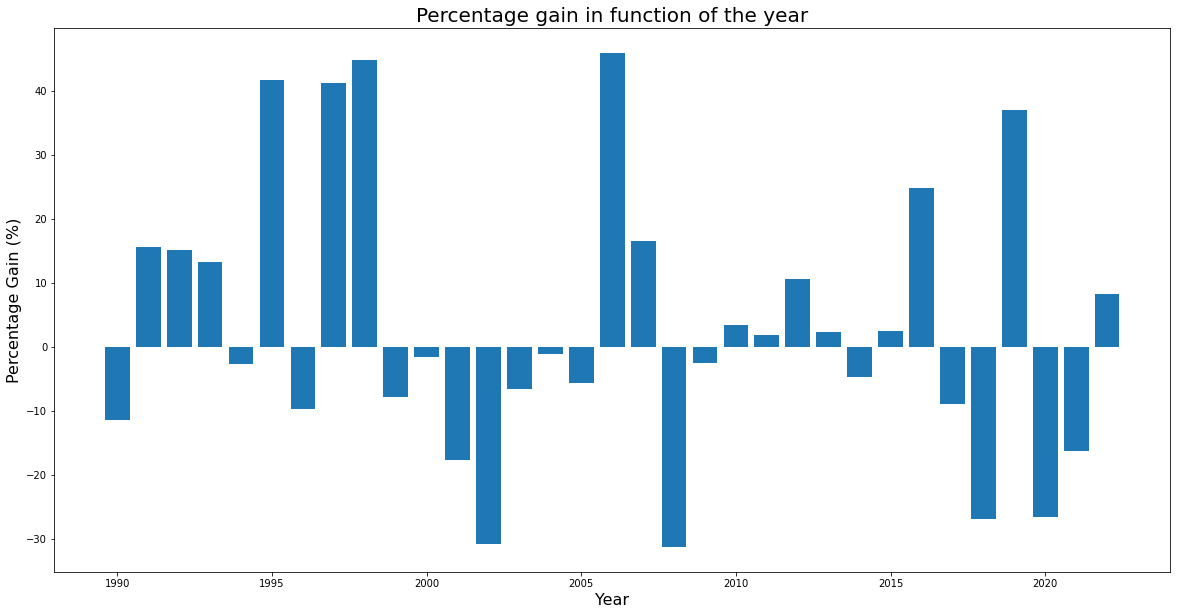

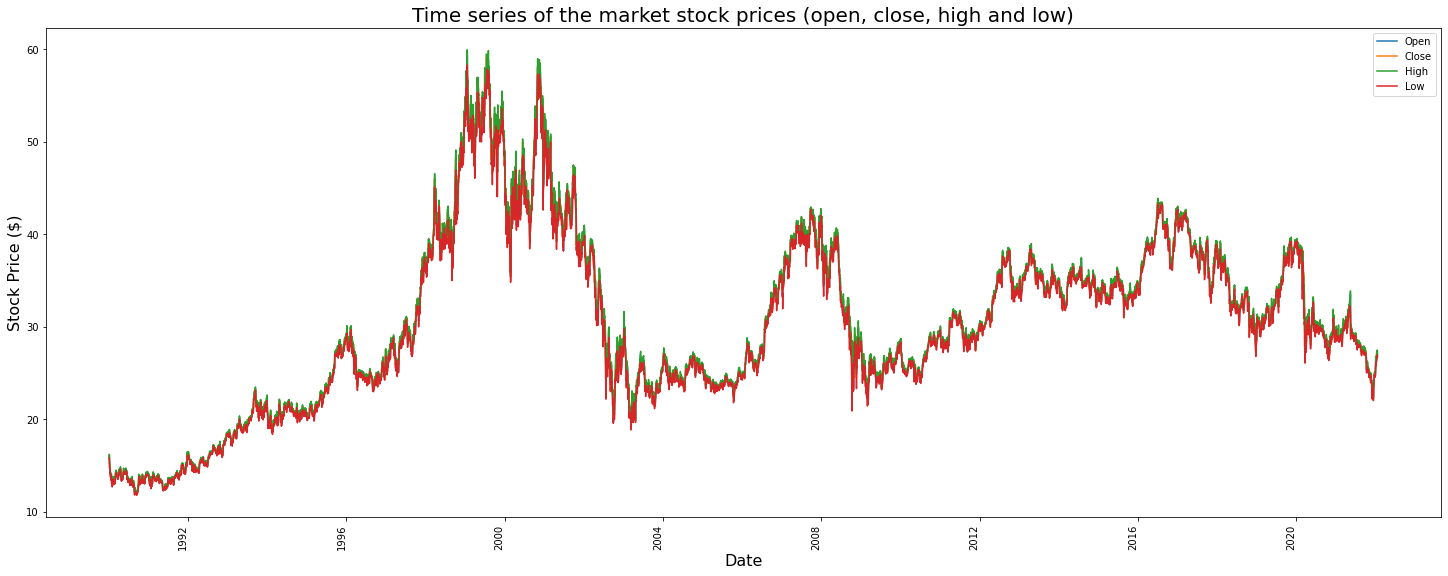

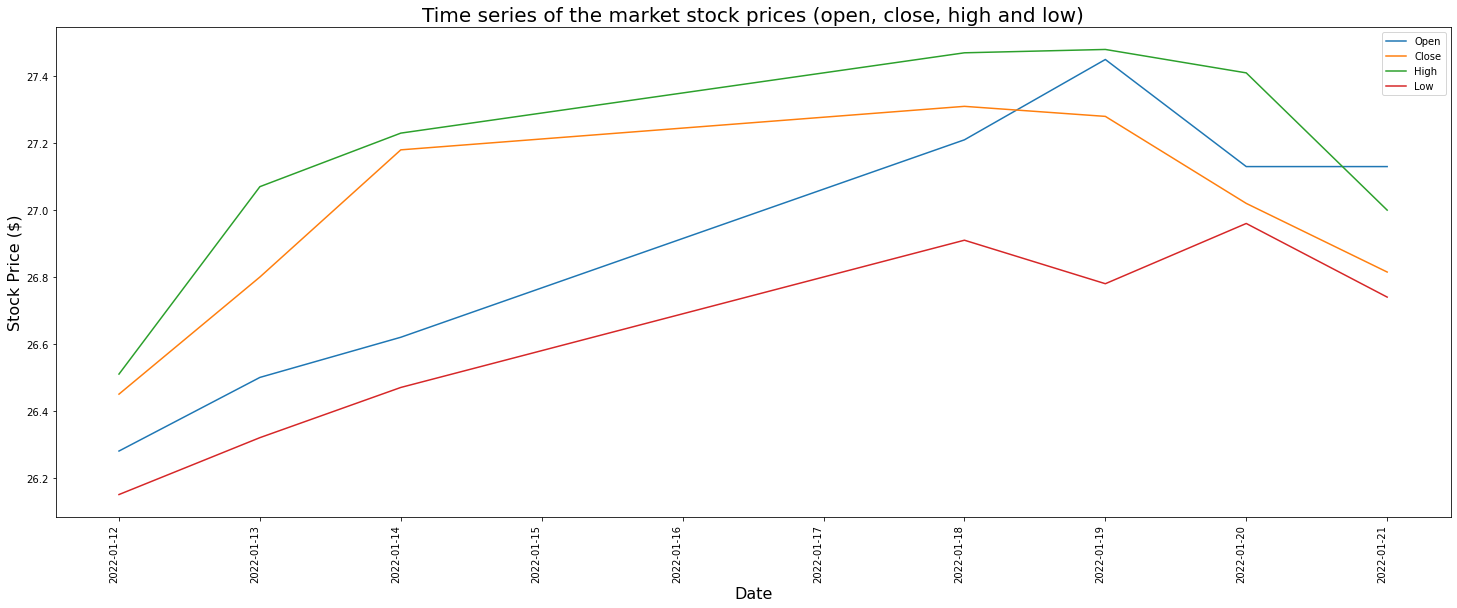

In [7]:
installPackageIfNotInstalled("ipywidgets")
import ipywidgets as widgets

# Event OnChange of the dropdown list.
def onChangeCompany(change):
    if change['new'] != change['old']:
        clear_output()
        display(dropdown_cies)

        if change['new'] != "(Select a company)":
            Dashboard.displayLastDayStockPriceAndGain(stock_indices, change['new'])
            display(percentage_gains.loc[percentage_gains['CompanyName'] == change['new'], 'Year':'PercentageGain'])
            Dashboard.plotPercentageGainPerYear(percentage_gains, change['new'])
            Dashboard.plotStockPriceTimeSeries(stock_indices, change['new'])
            Dashboard.plotStockPriceTimeSeries(stock_indices, change['new'], last_days = 7)


options = sorted(set(percentage_gains['CompanyName']))
options.insert(0, "(Select a company)")
dropdown_cies = widgets.Dropdown(options=options,
                                 value=options[0],
                                 description="Company ")
display(dropdown_cies)

# Observer on the onChange event of the dropdown list.
dropdown_cies.observe(onChangeCompany, names='value')

## Top Gainers and Losers
The objective is to determine which companies have the greatest and lowest percentage gain in function of a certain period of time.

In [8]:
def getFromDate(option, last_date):
    return {
        'Last day': last_date - pd.DateOffset(days=1),
        'Last week': last_date - pd.DateOffset(weeks=1),
        'Last month': last_date - pd.DateOffset(months=1),
        'Last year': last_date - pd.DateOffset(years=1),
        'The beginning': pd.to_datetime('1990-01-01')
    }.get(option, last_date - pd.DateOffset(days=1))

# Event OnChange of the dropdown list.
def onChangePeriod(change):
    if change['new'] != change['old']:
        clear_output()
        display(dropdown_period)
        
        if change['new'] != "(Select a period)":
            last_date = stock_indices['Date'].iloc[-1]
            from_date = getFromDate(change['new'], last_date)
            Dashboard.showBiggestCiesGainerOverTime(stock_indices, from_date)

options = ["(Select a period)" ,"Last day", "Last week", "Last month", "Last year" ,"The beginning"]
dropdown_period = widgets.Dropdown(options=options,
                                   value=options[0],
                                   description="Since ")
display(dropdown_period)

# Observer on the onChange event of the dropdown list.
dropdown_period.observe(onChangePeriod, names='value')

Dropdown(description='Since ', index=1, options=('(Select a period)', 'Last day', 'Last week', 'Last month', '…

From: 2022-01-20


,CompanyName,Open,Close,PercentageGain
376,Prologis,151.990005,156.737503,3.123559
97,Cboe Global Markets,117.199997,120.660004,2.952224
440,The Travelers Companies,162.440002,166.585007,2.551714
241,IQVIA,241.509995,247.190002,2.351873
99,Centene Corporation,77.610001,79.389999,2.293517
...,...,...,...,...
206,Garmin,131.990005,121.919998,-7.629371
289,LyondellBasell,102.099998,94.059998,-7.874634
441,The Walt Disney Company,150.904999,139.000000,-7.889069
290,M&T Bank,178.770004,161.264999,-9.791914
